# 実験3-3 CNN の特徴抽出

ここでは，CNN を用いて，中間層がどのような働きをしているかを考えてみます．
道具としては演習 3-1, 3-2 で用いたクラスタリング手法と次元圧縮手法を用います．

ここでは比較的単純な `ResNet18` モデルを題材に考えていきます．

- 未学習の ResNet18 モデルの特徴表現
- 学習済み ResNet18 モデルの特徴表現
- ファインチューニングされた ResNet18 モデルの特徴表現

これらのモデルの未知の画像に対する反応を取り出して，次元圧縮してCNNが画像をどのように見ているのかを可視化することを考えます．

方法としては，対象としたモデルに対して，適切な特徴抽出層を定め，
未知の画像を入力して，そこの出力を引っ張り出します．この出力は，画像を変換したものなので，
CNN が見ている世界に他なりません．ただし高次元の特徴になっているために，次元圧縮とクラスタリングを使って可視化する，
というのが今回の演習の趣旨になります．


## ResNet18 をいじくる

それでは `pytorch` で提供されている ResNet18 を弄くって，適切なモデルを再構築します．
といっても，最後の識別層である `(fc)` 層を外すだけです．

また，ファインチューニングする場合は，前回のファインチューニングの回と同じ要領で行うことになります．
提供されている ResNet18 モデルは，`ImageNet1K` と呼ばれる1000クラスの画像データセットで学習されていますが，
ここで対象としている画像セットは `CIFAR10` を対象とします．CIFAR10 は 10 クラス分のデータセットですので，
1000 クラス分類するための `fc` 層を新たな 10クラス分の `fc` 層に取り替えて学習させ，その後，最後の層を外せばよいです．

ここでは単純に取り払って，事前学習済みのモデルを調べていきます．

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18

# ResNet18モデル（事前学習済み）
model = resnet18(weights='DEFAULT') # ここで weights を指定しなければ，未学習のモデルとなる

# fc 層の直前（avgpool層） までの部分モデルを作成（最後の1層をとっぱらったモデル）
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## データの収集

あとは，作成した `feature_extractor` モデルに，目的である `CIFAR10` を入力していきます．
なお，画像の基本的な部分をあわせるため，平均と標準偏差を事前学習データである ImageNet1K に合わせるところは注意が必要です．

ファインチューニングを施して学習させる場合は，CIFAR10 の平均と標準偏差に合わせたほうが良いので，`transform` を
```python:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 用にリサイズ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
```
あたりにしたほうが良いかもしれません．

In [2]:
import numpy as np

# データ準備
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 用にリサイズ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #事前学習した ImageNet1K の平均と標準偏差にあわせる
])
cifar10 = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(cifar10, batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# モデルを評価モードにして，データを喰わせる
feature_extractor.eval()

# 特徴抽出
features = []
labels = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        outputs = feature_extractor(inputs)
        features.append(outputs.cpu().numpy()) # GPU上のテンソルをCPU上に持ってくる
        labels.extend(targets.numpy())

features = np.concatenate(features)

# ここで features は (10000, 512, 1, 1) の形状になっているはずなので，(10000, 512) に変形する
features = features.squeeze(axis=(2, 3))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


## 可視化

それでは，この特徴がクラスタリングできそうかどうか見ていきましょう．教師なし学習の場合は，ラベルを必要としないためにデータ表現の似た者同士を同じグループ（クラスタ）に入れていきます．
まずは K-means 法でクラスタリングして，それを PCA で圧縮した次元で眺めてみます．


Text(0.5, 0.92, 'K-means on CNN Features')

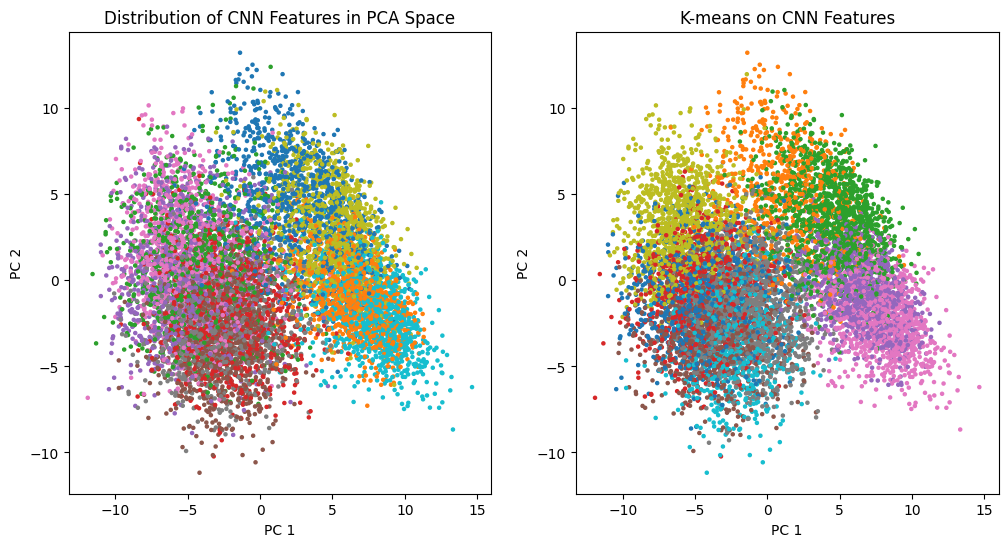

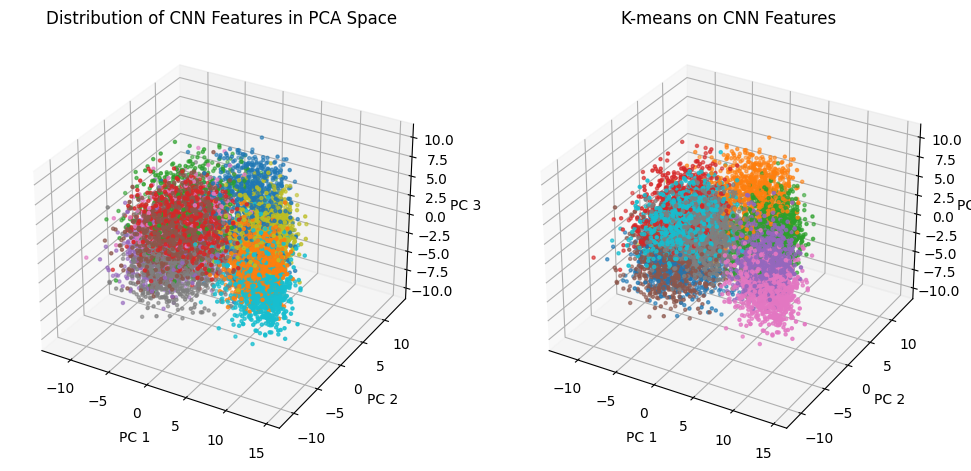

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# K-meansクラスタリング
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(features)

# プロット（次元削減後）
pca = PCA(n_components=10)
features_pca = pca.fit_transform(features)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10', s=5)
ax[0].set_title('Distribution of CNN Features in PCA Space')
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='tab10', s=5)
ax[1].set_title('K-means on CNN Features')
ax[1].set_xlabel('PC 1')
ax[1].set_ylabel('PC 2')


# 3次元に拡張してプロットもしてみる

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=labels, cmap='tab10', s=5)
ax0.set_xlabel('PC 1')
ax0.set_ylabel('PC 2')
ax0.set_zlabel('PC 3')
ax0.set_title('Distribution of CNN Features in PCA Space')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=cluster_labels, cmap='tab10', s=5)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_zlabel('PC 3')
ax1.set_title('K-means on CNN Features')



図の左側が，`CIFAR 10` についているラベルで，特徴を色分けしたもので，右側が K-means 法で色分けしたものです．
なんとなくですが，色関係の対応が見えるような気がします．

もう少しはっきりと可視化させたい場合は，`t-SNE` の出番です．

Text(0, 0.5, 'TSNE 2')

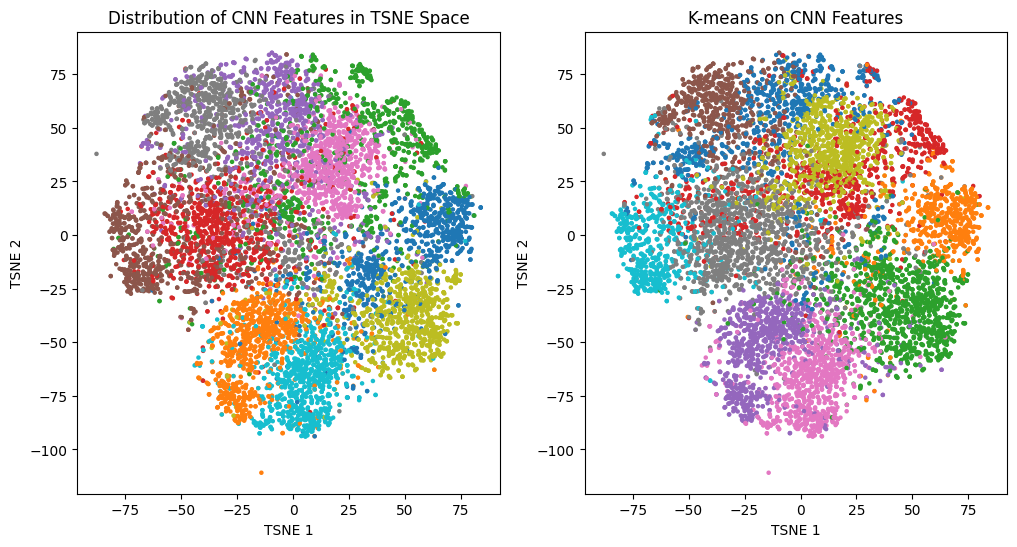

In [17]:
# TSNE で次元圧縮

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10)
features_tsne = tsne.fit_transform(features)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10', s=5)
ax[0].set_title('Distribution of CNN Features in TSNE Space')
ax[0].set_xlabel('TSNE 1')
ax[0].set_ylabel('TSNE 2')
ax[1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels, cmap='tab10', s=5)
ax[1].set_title('K-means on CNN Features')
ax[1].set_xlabel('TSNE 1')
ax[1].set_ylabel('TSNE 2')


今度は，かなり島状にデータが分布していて一部のデータはかなりきれいに分離できているのがわかります．

## 実験3-3

1. 未学習の ResNet18 モデルに対して，上記と同様の特徴の分布の分析を行いなさい．
2. 学習済みの ResNet18 にファインチューニングを施し，上記と同様の特徴の分布の分析を行いなさい．
3. それぞれの特徴の表現が学習のなかでどの様に変化するかを考察しなさい．
